hepsini maks uzunluk yapacağına bölüm bölüm ayırarak uzunluk halletme kodu vardı onu yap süre azalsın.

In [15]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sklearn
from tqdm import tqdm
df = pd.read_csv('movie10k.csv')

In [16]:
df.isnull().sum()
#0 null so no need to clear null
print(df.duplicated().sum())
#418 duplicated, no we need to clear duplicates
df=df.drop_duplicates() 
print(df.duplicated().sum())
#duplicates are cleared
df.head()

13
0


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [17]:
import re
def stringClear(text):
    cleanText = re.sub(r'[!,.""?''()]',' ',text)
    return cleanText

df['text'] = df['text'].apply(stringClear)
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,label
0,i grew up b 1965 watching and loving the th...,0
1,when i put this movie in my dvd player and sa...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [18]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWordList = stopwords.words("english")

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stopWordList]).apply(lambda x:" ".join(x))
#unnecessary words are eliminated
df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eceok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1
5,terrible movie everyone said made laugh cameo ...,0
6,finally watched shocking movie last night dist...,1
7,caught film azn cable sounded like would good ...,0
8,may remake 1987 autumn's tale eleven years dir...,1
9,super ex girlfriend turned pleasant surprise r...,1


In [19]:

def catAsNum(val):
    if val=="positive":
        return 1
    else:
        return 0
#df['label']  =  df['label'].apply(catAsNum)

In [20]:
x = df["text"].values
y = df["label"].values

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(7989,)
(1998,)
(7989,)
(1998,)


In [22]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(list(x_train), padding = "max_length", truncation=True)
test_encodings = tokenizer(list(x_test), padding = "max_length", truncation=True)

BATCHSIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(BATCHSIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(BATCHSIZE)

In [23]:
for x, y in test_dataset:
   print(x, y)

{'input_ids': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[ 101, 2738, 2693, ...,    0,    0,    0],
       [ 101, 5409, 3185, ...,    0,    0,    0],
       [ 101, 7059, 3946, ...,    0,    0,    0],
       ...,
       [ 101, 3383, 2402, ...,    0,    0,    0],
       [ 101, 1045, 1005, ...,    0,    0,    0],
       [ 101, 4089, 2028, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} tf.Tensor(
[0 0 0 1 0 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 

In [24]:
""" 
import tensorflow_datasets as tfds
train_dataframe = tfds.as_dataframe(train_dataset) 
test_dataframe = tfds.as_dataframe(test_dataset) 
"""

' \nimport tensorflow_datasets as tfds\ntrain_dataframe = tfds.as_dataframe(train_dataset) \ntest_dataframe = tfds.as_dataframe(test_dataset) \n'

In [25]:
id2label = {
    0 : 'Negative',
    1 : 'Positive'
}

label2id = {v : k for k, v in id2label.items()}
num_classes = len(label2id)
print(label2id)

{'Negative': 0, 'Positive': 1}


In [26]:
#cased
from transformers import TFAutoModelForSequenceClassification
model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    label2id = label2id,
    id2label = id2label
)

model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), #hyperparameter
    metrics = ["accuracy"] #hyperparameter sayılır
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
EPOCHS = 1 #hyperparameter
history = model.fit(
    train_dataset,
    validation_data = test_dataset,
    epochs = EPOCHS  
)

125/125 [==============================] - 45068s 361s/step - loss: 0.3829 - accuracy: 0.8330 - val_loss: 0.2707 - val_accuracy: 0.8744


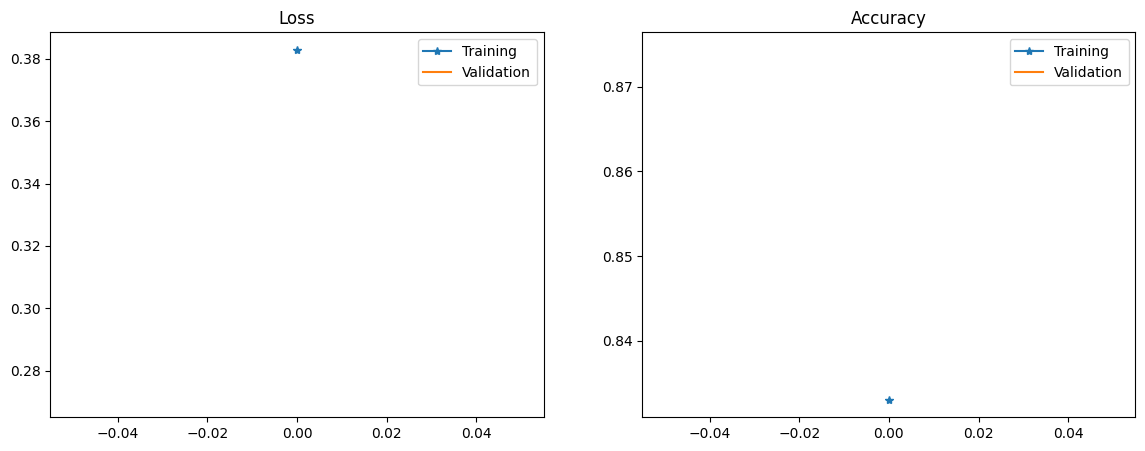

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

In [32]:
out = model.predict(test_dataset)
pred = np.argmax(out[0], axis = 1)
pred

32/32 [==============================] - 3697s 116s/step


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

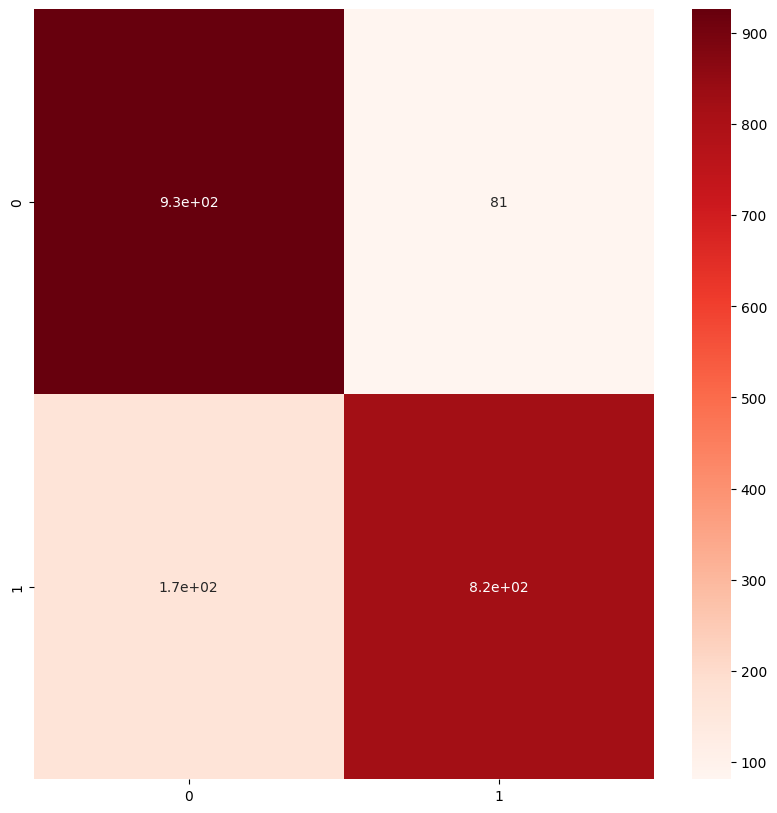

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred)
plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, cmap='Reds')
plt.show()